# Trotterization with light-cone ordering (short-time)

In [1]:
from qiskit.quantum_info import SparsePauliOp, random_statevector
from functools import partial
import multiprocessing

import scipy.sparse.linalg as ssla
from scipy import sparse
import pandas as pd
import scipy, jax

import matplotlib.pyplot as plt
import numpy as np

from utils import *
from spin_ham import *
from trotter import *
from bounds import *
from dqpt  import *

figs_dir, data_dir = './figs', './data'


plt.rc('axes', labelsize=LARGE_SIZE+3)  # fontsize of the x and y labels
mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.markeredgewidth'] = 1.5
mpl.rcParams['lines.linewidth'] = 2.0


## Nearest-neighbor Heisenberg model

In [19]:
prefix, suffix = 'NNH', 'n'  # 'TFI', 'n'
use_jax = True
n_bnd_max = 200 # 400,  100,  200,  250
# n_list_bnd = [5, 6, 7, 8, 9, 10, 12, 15, 18, 23, 29, 36, 44, 55, 68, 84, 105, 130, 161, 198]
n_list_bnd = [5, 6, 7, 8, 9, 10, 12, 15, 18, 23, 29, 36, 44, 55, 68, 84, 105, 130, 161]
# n_list_bnd = [5, 6, 7, 8, 9, 10, 12, 15, 18, 23, 29, 36, 44, 55, 68, 84]
# n_list_bnd = []
# n_list_bnd = [5, 6, 7, 8, 9, 10, 12, 15, 18, 23, 29, 36, 44, 55, 68, 84, 105, 130, 161, 199, 249]
r_max = n_bnd_max
n_max, n_min = 9, 5  #  9, 5 ;  12, 5 
# n_max, n_min = 10, 5  #  9, 5 ;  12, 5 
J, h = 1, 0.3 # 1, 1 ;  0.2, 0.2 ;  1, 0.2
t, eps = 0.1, 0.005

field_list = [random.gauss(0, 0.1) for _ in range(n_bnd_max)]
# print('random field: ', field_list)
n_list_emp = np.arange(n_min, n_max+1)
print('n_list_emp: ', n_list_emp)

n_list_emp:  [5 6 7 8 9]


In [20]:
data_keys = ['worst', 'singl', 'multi', 'n']
bnd_data = dict([(k, []) for k in data_keys])
emp_data = dict([(k, []) for k in data_keys])
bnd_data['n'], emp_data['n'] = n_list_bnd, n_list_emp

r_start_worst_bnd, r_start_singl_bnd, r_start_multi_bnd = 1, 1, 1
r_end_worst_bnd, r_end_singl_bnd, r_end_multi_bnd = r_max-1, r_max-1, r_max-1

import multiprocess as mp
PROCESSES = 10
for i, n in enumerate(n_list_bnd):
    hnn = Nearest_Neighbour_1d(n, Jx=J, Jy=J, Jz=J, hx=h, hy=0, hz=0, pbc=False, rand_field=field_list)
    # r_start, r_end = 1, int(n/2)
    print(f'-------------- n (bound) = {n} --------------')
    bnd_worst_err_r = partial(measure_error, h_list=None, t=t, exact_U=None, type='worst_loose_bound', coeffs=['singl', n, hnn])
    
    r_worst_bnd = binary_search_r(r_start_worst_bnd, r_end_worst_bnd, eps, bnd_worst_err_r, comment='worst_bnd',verbose=True)
    r_end_worst_bnd, r_end_singl_bnd, r_end_multi_bnd = r_worst_bnd+10, r_worst_bnd, r_worst_bnd
    # bnd_worst_err_r = partial(measure_error, h_list=None, t=t, exact_U=None, type='worst_loose_bound', coeffs=['singl', n, cmm_data])
    # bnd_singl_err_r = partial(measure_error, h_list=None, t=t, exact_U=None, type='lightcone_bound', coeffs=['singl', n, tail_cmm_data])
    # bnd_singl_err_r = partial(measure_error, h_list=None, t=t, exact_U=None, type='lightcone_bound', coeffs=['singl', n, hnn, 0, 0])
    right, left = 0, 0
    print('prepare single ob table...')
    def singl_ob_cmm(j):
        h_list_z = lc_group(hnn, right, left, 2*j, verbose=False, legacy=True)
        c1_cmm_z, c2_cmm_z = nested_commutator_norm(h_list_z)
        return c1_cmm_z, c2_cmm_z
        # return 2 * (c1_cmm_z * dt**3 / 12 + c2_cmm_z * dt**3 / 24)
    with mp.Pool(PROCESSES) as pool:
        singl_data= pool.map(singl_ob_cmm, range(1, r_end_singl_bnd+1))
    # print('singl_data: ', singl_data)

    print('prepare multi ob table...')
    def multi_z_cmm(j):
        h_list_z_list = [lc_group(hnn, i, i, 2*j+2, verbose=False) for i in range(0, n)]
        # h_list_zz_list = [lc_group(h, i, i+1, 2*j+2, verbose=False) for i in range(0, n-1)]
        tail_cmm_data = np.array([nested_commutator_norm(h_list_z) for h_list_z in h_list_z_list])
        # tail_cmm_data = np.array([nested_commutator_norm(h_list_zz) for h_list_zz in h_list_zz_list])
        return tail_cmm_data
        # return 2 * (c1_cmm_z * dt**3 / 12 + c2_cmm_z * dt**3 / 24)
    with mp.Pool(PROCESSES) as pool:
        multi_z_data= pool.map(multi_z_cmm, range(1, r_end_multi_bnd+1))
    # print('multi_z_data: ', multi_z_data)
    # print(r_end_singl_bnd, r_end_multi_bnd)

    bnd_singl_err_r = partial(measure_error, h_list=None, t=t, exact_U=None, type='lightcone_bound_table', coeffs=['singl', n, singl_data])
    # bnd_multi_err_r = partial(measure_error, h_list=None, t=t, exact_U=None, type='lightcone_bound', coeffs=['multi_z', n, hnn, 0, 0])
    bnd_multi_err_r = partial(measure_error, h_list=None, t=t, exact_U=None, type='lightcone_bound_table', coeffs=['multi_z', n, multi_z_data])

    r_singl_bnd = binary_search_r(r_start_singl_bnd, r_end_singl_bnd, eps, bnd_singl_err_r, comment='singl_bnd',verbose=True)
    r_multi_bnd = binary_search_r(r_start_multi_bnd, r_end_multi_bnd, eps, bnd_multi_err_r, comment='multi_bnd',verbose=True)
    bnd_data['worst'].append(r_worst_bnd)
    bnd_data['singl'].append(r_singl_bnd)
    bnd_data['multi'].append(r_multi_bnd)
    r_start_worst_bnd, r_start_singl_bnd, r_start_multi_bnd = r_worst_bnd, r_singl_bnd, r_multi_bnd

r_start_worst_emp, r_start_singl_emp, r_start_multi_emp, r_end = 1, 1, 1, r_max-1
for n in n_list_emp:
    print(f'-------------- n (empirical) = {n} --------------')
    # hnn = Nearest_Neighbour_1d(n, Jx=J, Jy=0, Jz=0, hx=0, hy=0, hz=h, pbc=False, verbose=False)
    # hnn = Nearest_Neighbour_1d(n, Jx=0, Jy=0, Jz=J, hx=h, hy=0, hz=0, pbc=False, verbose=False)
    # hnn = Nearest_Neighbour_1d(n, Jx=J, Jy=J, Jz=J, hx=h, hy=0, hz=0, pbc=False, verbose=False)
    hnn = Nearest_Neighbour_1d(n, Jx=J, Jy=J, Jz=J, hx=h, hy=0, hz=0, pbc=False, rand_field=field_list)
    # field_list = hnn.rand_field
    singl_ob = SparsePauliOp.from_sparse_list([('Z', [0], 1)], n).to_matrix()
    # multi_ob = SparsePauliOp.from_sparse_list([('Z', [i], 1/n) for i in range(0, n)], n).to_matrix()
    # multi_ob = SparsePauliOp.from_sparse_list([('Y', [i], 1) for i in range(0, n)], n).to_matrix()
    multi_ob = SparsePauliOp.from_sparse_list([('ZZ', [i,i+1], 1) for i in range(0, n-1)], n).to_matrix()
    # multi_ob = SparsePauliOp.from_sparse_list([(random.choice(['X','Y','Z']), [i], 1) for i in range(0, n)], n).to_matrix()
    print('multi ob norm: ', np.linalg.norm(multi_ob, ord=2))
    multi_ob = multi_ob / np.linalg.norm(multi_ob, ord=2)
    par_group = [h.to_matrix() for h in hnn.ham_par]
    # par_group = [h.to_matrix() for h in hnn.ham_par][::-1]
    xyz_group = [h.to_matrix() for h in hnn.ham_xyz]

    exact_U = jax.scipy.linalg.expm(-1j * t * sum([h for h in par_group]))
    # verfiy the exact_U
    assert np.allclose(exact_U, jax.scipy.linalg.expm(-1j * t * sum([h for h in xyz_group])))

    emp_worst_err_r = partial(measure_error, h_list=par_group, t=t, exact_U=exact_U, type='worst_empirical', use_jax=use_jax)
    emp_singl_err_r = partial(measure_error, h_list=par_group, t=t, exact_U=exact_U, ob=singl_ob, type='worst_ob_empirical', use_jax=use_jax)
    emp_multi_err_r = partial(measure_error, h_list=par_group, t=t, exact_U=exact_U, ob=multi_ob, type='worst_ob_empirical', use_jax=use_jax)

    r_worst_emp = binary_search_r(r_start_worst_emp, r_end, eps, emp_worst_err_r, comment='worst_emp', verbose=True)
    r_singl_emp = binary_search_r(r_start_singl_emp, r_end, eps, emp_singl_err_r, comment='singl_emp',verbose=True)
    r_multi_emp = binary_search_r(r_start_multi_emp, r_end, eps, emp_multi_err_r, comment='multi_emp',verbose=True)
    emp_data['worst'].append(r_worst_emp)
    emp_data['singl'].append(r_singl_emp)
    emp_data['multi'].append(r_multi_emp)
    r_start_worst_emp, r_start_singl_emp, r_start_multi_emp = r_worst_emp, r_singl_emp, r_multi_emp

print('emp_data: ', emp_data)
# print(pd.DataFrame(emp_data))
# save to csv
pd.DataFrame(emp_data).to_csv(f'{data_dir}/{prefix}_emp_lightcone_max={n_max}_bnd_max={n_bnd_max}_{suffix}.csv', index=False)
pd.DataFrame(bnd_data).to_csv(f'{data_dir}/{prefix}_bnd_lightcone_max={n_max}_bnd_max={n_bnd_max}_{suffix}.csv', index=False)
pd.DataFrame(bnd_data)

-------------- n (bound) = 5 --------------
----[worst_bnd] binary search r (r_start=1, r_end=199)----
r_start: 1 ; r_end: 100
r_start: 1 ; r_end: 50
r_start: 1 ; r_end: 25
r_start: 1 ; r_end: 13
r_start: 1 ; r_end: 7
r_start: 1 ; r_end: 4
r_start: 2 ; r_end: 4
r_start: 3 ; r_end: 4
r: 4 ; err:  0.004385344088402712
prepare single ob table...


prepare multi ob table...
----[singl_bnd] binary search r (r_start=1, r_end=4)----
r_start: 2 ; r_end: 4
r_start: 3 ; r_end: 4
r: 4 ; err:  0.004145017884227754
----[multi_bnd] binary search r (r_start=1, r_end=4)----
r_start: 2 ; r_end: 4
r_start: 3 ; r_end: 4
r: 4 ; err:  0.004289694896274805
-------------- n (bound) = 6 --------------
----[worst_bnd] binary search r (r_start=4, r_end=14)----
r_start: 4 ; r_end: 9
r_start: 4 ; r_end: 6
r_start: 4 ; r_end: 5
r: 5 ; err:  0.0037199105583442804
prepare single ob table...
prepare multi ob table...
----[singl_bnd] binary search r (r_start=4, r_end=5)----
r: 5 ; err:  0.0036919818205682787
----[multi_bnd] binary search r (r_start=4, r_end=5)----
r: 5 ; err:  0.0036741975356098825
-------------- n (bound) = 7 --------------
----[worst_bnd] binary search r (r_start=5, r_end=15)----
r: 5 ; err:  0.004971962624550365
prepare single ob table...
prepare multi ob table...
----[singl_bnd] binary search r (r_start=5, r_end=5)----
r: 5 ; err:  0.004

    worst  singl  multi    n
0       4      4      4    5
1       5      5      5    6
2       5      5      5    7
3       6      6      6    8
4       6      6      6    9
5       7      6      7   10
6       8      6      7   12
7       9      7      8   15
8      10      7      9   18
9      11      7     10   23
10     13      7     10   29
11     14      7     11   36
12     15      7     12   44
13     17      7     12   55
14     19      7     12   68
15     22      7     13   84
16     24      7     13  105
17     27      7     13  130
a_em: 1.5466829204743118; b_em: 2.740900885149304
a_em: 2.242644827184909e-08; b_em: 6.073044433788678
a_em: 1.1111443152481635; b_em: 4.119356472820146
a_em: 3.592724858928498e-08; b_em: 2.639057257804911
a_em: 1.0000000000000018; b_em: 2.7725887222397776


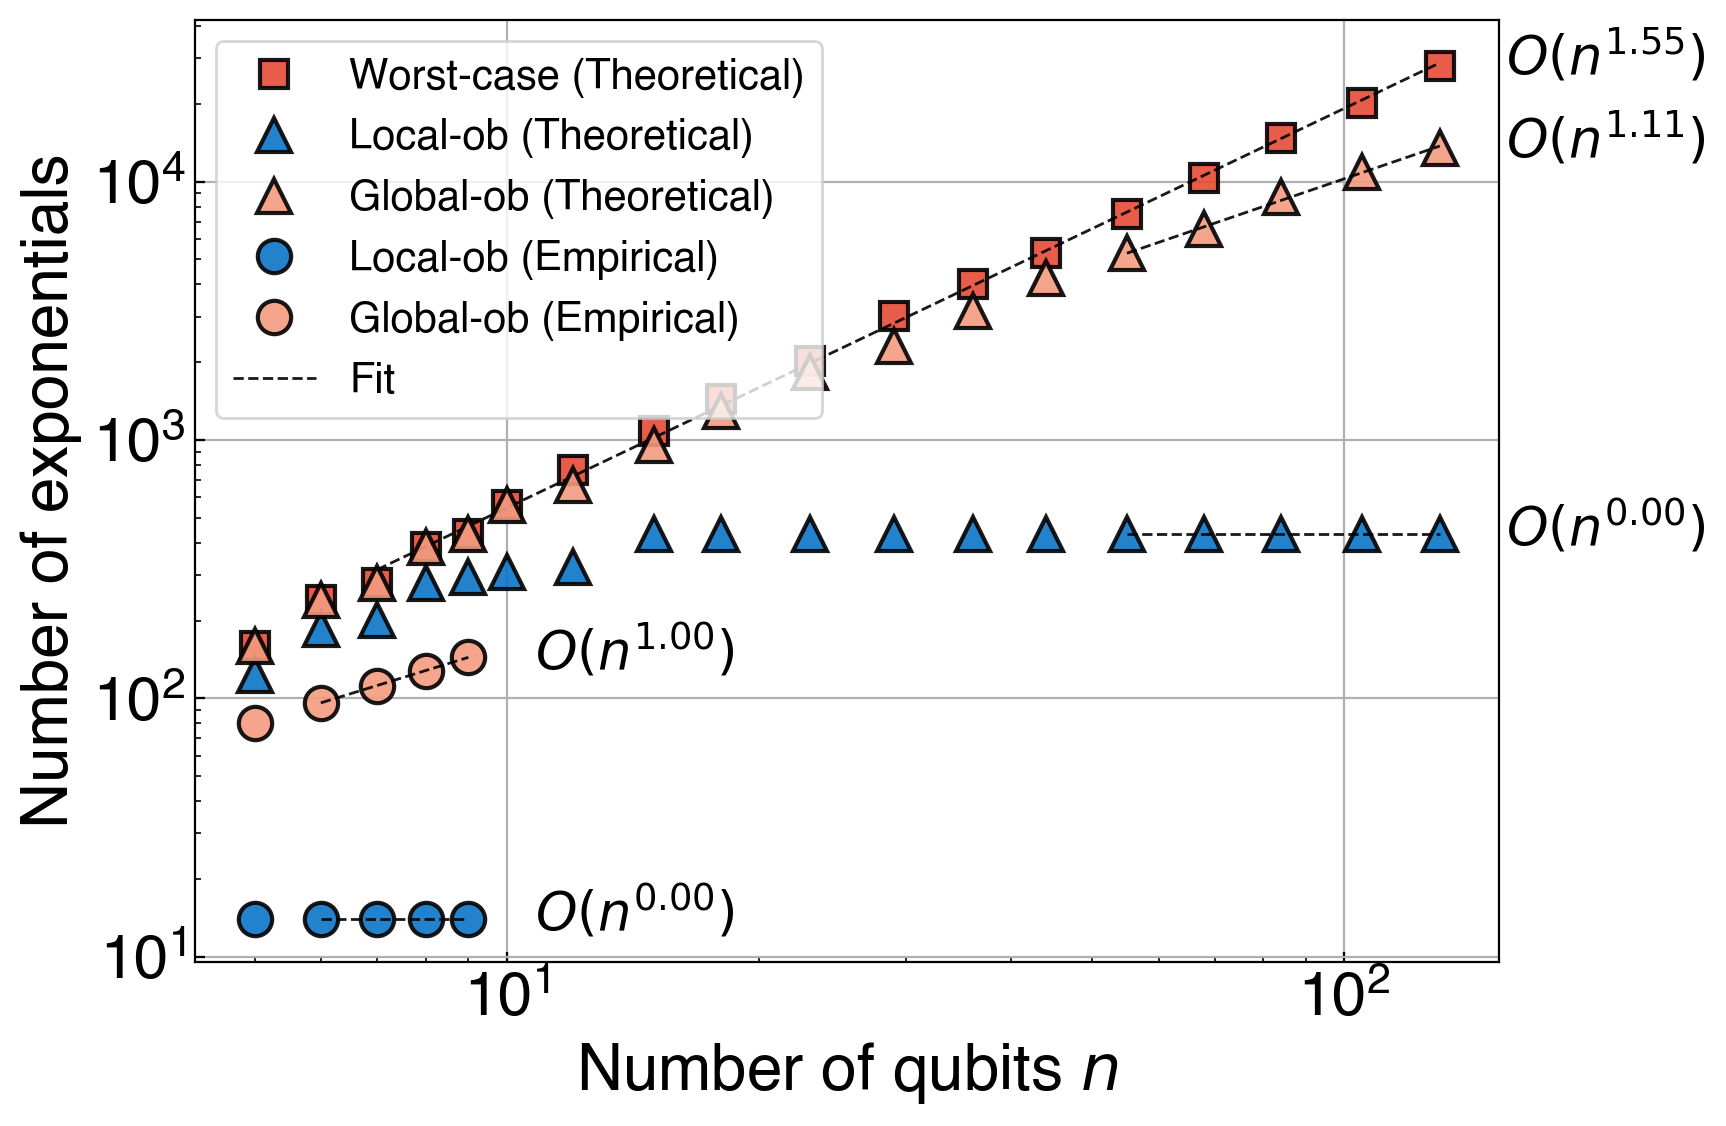

In [18]:
plt.rc('legend', fontsize=MEDIUM_SIZE-1) 

if prefix == 'TFI':
    factor = 2
elif prefix == 'NNH':
    factor = 4

emp_data = pd.read_csv(f'{data_dir}/{prefix}_emp_lightcone_max={n_max}_bnd_max={n_bnd_max}_{suffix}.csv')
bnd_data = pd.read_csv(f'{data_dir}/{prefix}_bnd_lightcone_max={n_max}_bnd_max={n_bnd_max}_{suffix}.csv')
print(bnd_data)

def exp_count_LC(r, n_qubits, n_terms):
    exp_count = 0
    for i in range(1, r+1):
        # print('i: ', i)
        if i < int(n_qubits/2):
            exp_count += (2*factor * i - 1) * 2    
            # exp_count += (4 * i - 1) * 2    
        elif i == int(n_qubits/2):
            exp_count += (2*factor * i - 1) * 2  - 1
        else:
            exp_count += n_terms * 2
    return exp_count

cost_st_list = [2 * factor*bnd_data['n'][i] * r for i, r in enumerate(bnd_data['worst'])]
cost_lc_list_s = [exp_count_LC(r, bnd_data['n'][i], factor*bnd_data['n'][i]) for i, r in enumerate(bnd_data['singl'])]
cost_lc_list_m = [2 * factor*bnd_data['n'][i] * r for i, r in enumerate(bnd_data['multi'])]
cost_em_list_s = [exp_count_LC(r, emp_data['n'][i], factor*emp_data['n'][i]) for i, r in enumerate(emp_data['singl'])]
cost_em_list_m =  [2 * factor*emp_data['n'][i] * r for i, r in enumerate(emp_data['multi'])]
cost_em_list_w =  [2 * factor*emp_data['n'][i] * r for i, r in enumerate(emp_data['worst'])]


fig, ax2 = plt.subplots(figsize=(9, 6), layout='tight')
# ob_string = 'XIII'
ax2.plot(n_list_bnd, cost_st_list, 's', color='#E64B35FF', label=r'Worst-case (Theoretical)', markersize=10)
plot_fit(ax2, n_list_bnd[2:], cost_st_list[2:], var=suffix, x_offset=1.20, y_offset=0.9)
# # ax2.plot(n_list, cost_st_found_list, 's', label=r'Worst-case (Ref \textcolor{blue}{[13]})', markersize=10)
ax2.plot(n_list_bnd, cost_lc_list_s, '^', color='#0A75C7', label='Local-ob (Theoretical)', markersize=12)
plot_fit(ax2, n_list_bnd[-7:], cost_lc_list_s[-7:], var=suffix, x_offset=1.20, y_offset=0.9)
ax2.plot(n_list_bnd, cost_lc_list_m, '^', color='#F39B7FFF', label='Global-ob (Theoretical)', markersize=12)
plot_fit(ax2, n_list_bnd[-7:], cost_lc_list_m[-7:], var=suffix, x_offset=1.20, y_offset=0.9)
# plot_fit(ax2, n_list_bnd[2:9], cost_lc_list_m[2:9], var=suffix, x_offset=1.06, y_offset=0.8)
# ax2.plot(n_list_emp, cost_em_list_w, 'D', color='#E64B35FF', label=r'Worst-case (Empirical)', markersize=10)
ax2.plot(n_list_emp, cost_em_list_s, 'o', color='#0A75C7', label='Local-ob (Empirical)')
plot_fit(ax2, n_list_emp[-4:], cost_em_list_s[-4:], var=suffix, x_offset=1.20, y_offset=0.9)
ax2.plot(n_list_emp, cost_em_list_m, 'o', color='#F39B7FFF', label='Global-ob (Empirical)')
plot_fit(ax2, n_list_emp[-4:], cost_em_list_m[-4:], var=suffix, x_offset=1.20, y_offset=0.9, label='Fit')
# ax2.plot(n_list, r_lc_found_list, '-*', label='Lightcone (bound)', markeredgecolor='k')
# Add labels and a legend
ax2.set_xlabel(f'Number of qubits $n$')
ax2.set_ylabel('Number of exponentials')
# ax2.set_title(fr'{prefix} Heisenberg (J={J}, h={h}, fix t={t}, $\epsilon$={eps}) PF2')  
ax2.loglog(); ax2.grid(); ax2.legend(loc='upper left')
fig.savefig(f'{figs_dir}/lightcone_NNH1d_J={J}_h={h}_n={n_list_emp[-1]}_nbnd={n_list_bnd[-1]}_eps={eps}_t={t}_2r.pdf', bbox_inches='tight')

## DQPT

In [121]:
n = 8
t_max, t_n = 3.0, 200
t_list = np.linspace(0, t_max, t_n)
# prefix = 'NNH' # 'Heisenberg'
prefix = 'TFI'

if prefix == 'TFI':
    factor = 2
elif prefix == 'NNH':
    factor = 4

# PBC is important
if prefix == 'TFI':
    H1d = Heisenberg_1d(n, Jx=0.0, Jy=0.0, Jz=0.2, hx=1.0, pbc=False, verbose=False)
elif prefix == 'NNH':
    H1d = Heisenberg_1d(n, Jx=0.2, Jy=0.2, Jz=0.2, hx=1.0, pbc=False, verbose=False)
else:
    raise ValueError('Invalid prefix')
H = H1d.ham
# h_list = [H1d.ham_xyz[0], H1d.ham_xyz[1], H1d.ham_xyz[2]]
h_list = H1d.ham_par

t_lc = 2.5
r_start_singl_bnd, r_end, eps = 1, n, 0.005
print('fixed eps: ', eps, '; t_lc: ', t_lc)
bnd_singl_err_r = partial(measure_error, h_list=None, t=t_lc, exact_U=None, type='lightcone_bound', coeffs=['singl', n, H1d])
r_lc_bnd = binary_search_r(r_start_singl_bnd, r_end, eps, bnd_singl_err_r, comment='singl_bnd',verbose=True)
print('LC Trotter r: ', r_lc_bnd)
gate_lc = exp_count_LC(r_lc_bnd, n, factor*n)
print('LC Trotter gate: ', gate_lc)
r_st_bnd = int(gate_lc / (2*factor*n)) + 1
print('standard Trotter r: ', r_st_bnd)
t_search_list = np.linspace(0.1, 2, 100)
error_list = np.array([measure_error(r_st_bnd, [h.to_matrix() for h in h_list], t, None, 'worst_bound', verbose=True) for t in t_search_list])
print(list(zip(t_search_list, error_list)))

def find_closest_index(lst, value):
    if len(lst) == 0:
        return None
    return min(range(len(lst)), key=lambda i: abs(lst[i] - value))

# new_error_list = [(error-eps)**2 for error in error_list]
# t_st_index = new_error_list.index(min(new_error_list))
# t_st = t_search_list[t_st_index]
t_st_index = find_closest_index(error_list, eps)
t_st = t_search_list[t_st_index]
print(f'standard Trotter t: {t_st}, error = {error_list[t_st_index]}')

fixed eps:  0.005 ; t_lc:  2.5
----[singl_bnd] binary search r (r_start=1, r_end=8)----
the initial r_end is too small, increase it by 10 times.
r_start: 1 ; r_end: 40
r_start: 1 ; r_end: 20
r_start: 10 ; r_end: 20
r_start: 15 ; r_end: 20
r_start: 15 ; r_end: 17
r_start: 16 ; r_end: 17
r: 17 ; err:  0.0045796865458986365
LC Trotter r:  17
LC Trotter gate:  487
standard Trotter r:  16
[(0.1, 3.782538327161523e-06), (0.1191919191919192, 6.405068450810369e-06), (0.1383838383838384, 1.002396300023164e-05), (0.1575757575757576, 1.4799653535507346e-05), (0.17676767676767677, 2.0892571616719466e-05), (0.19595959595959594, 2.8463148803950012e-05), (0.21515151515151515, 3.7671816657281004e-05), (0.23434343434343433, 4.8679006736794403e-05), (0.2535353535353535, 6.164515060257224e-05), (0.2727272727272727, 7.673067981469651e-05), (0.2919191919191919, 9.409602593324923e-05), (0.3111111111111111, 0.0001139016205183124), (0.3303030303030303, 0.00013630789512996799), (0.3494949494949495, 0.000161475

local observables:  ['IIIIIIII' 'ZIIIIIII']
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
echo_local_list:  [1.0, 0.9997727509166392, 0.9990912184966323, 0.9979560470196039, 0.9963683095831464, 0.9943295070508871, 0.9918415665812754, 0.9889068397385855, 0.9855281001880323, 0.981708540977352, 0.9774517714075858, 0.9727618134962442, 0.9676430980364272, 0.9621004602558932, 0.9561391350804677, 0.9497647520065883, 0.9429833295881788, 0.9358012695434111, 0.9282253504873541, 0.9202627212968042, 0.9119208941140511, 0.9032077369966234, 0.8941314662204567, 0.8847006382442645, 0.8749241413432358, 0.8648111869205043, 0.8543713005051707, 0.8436143124459767, 0.8325503483100091, 0.821189818996146, 0.8095434105732036, 0.7976220738530553, 0.7854370137092108, 0.772999678151655, 0.7603217471689326, 0.7474151213487381, 0.7342919102884511, 0.720964420807

Text(0, 0.5, 'Normalized rate function $r(t)$')

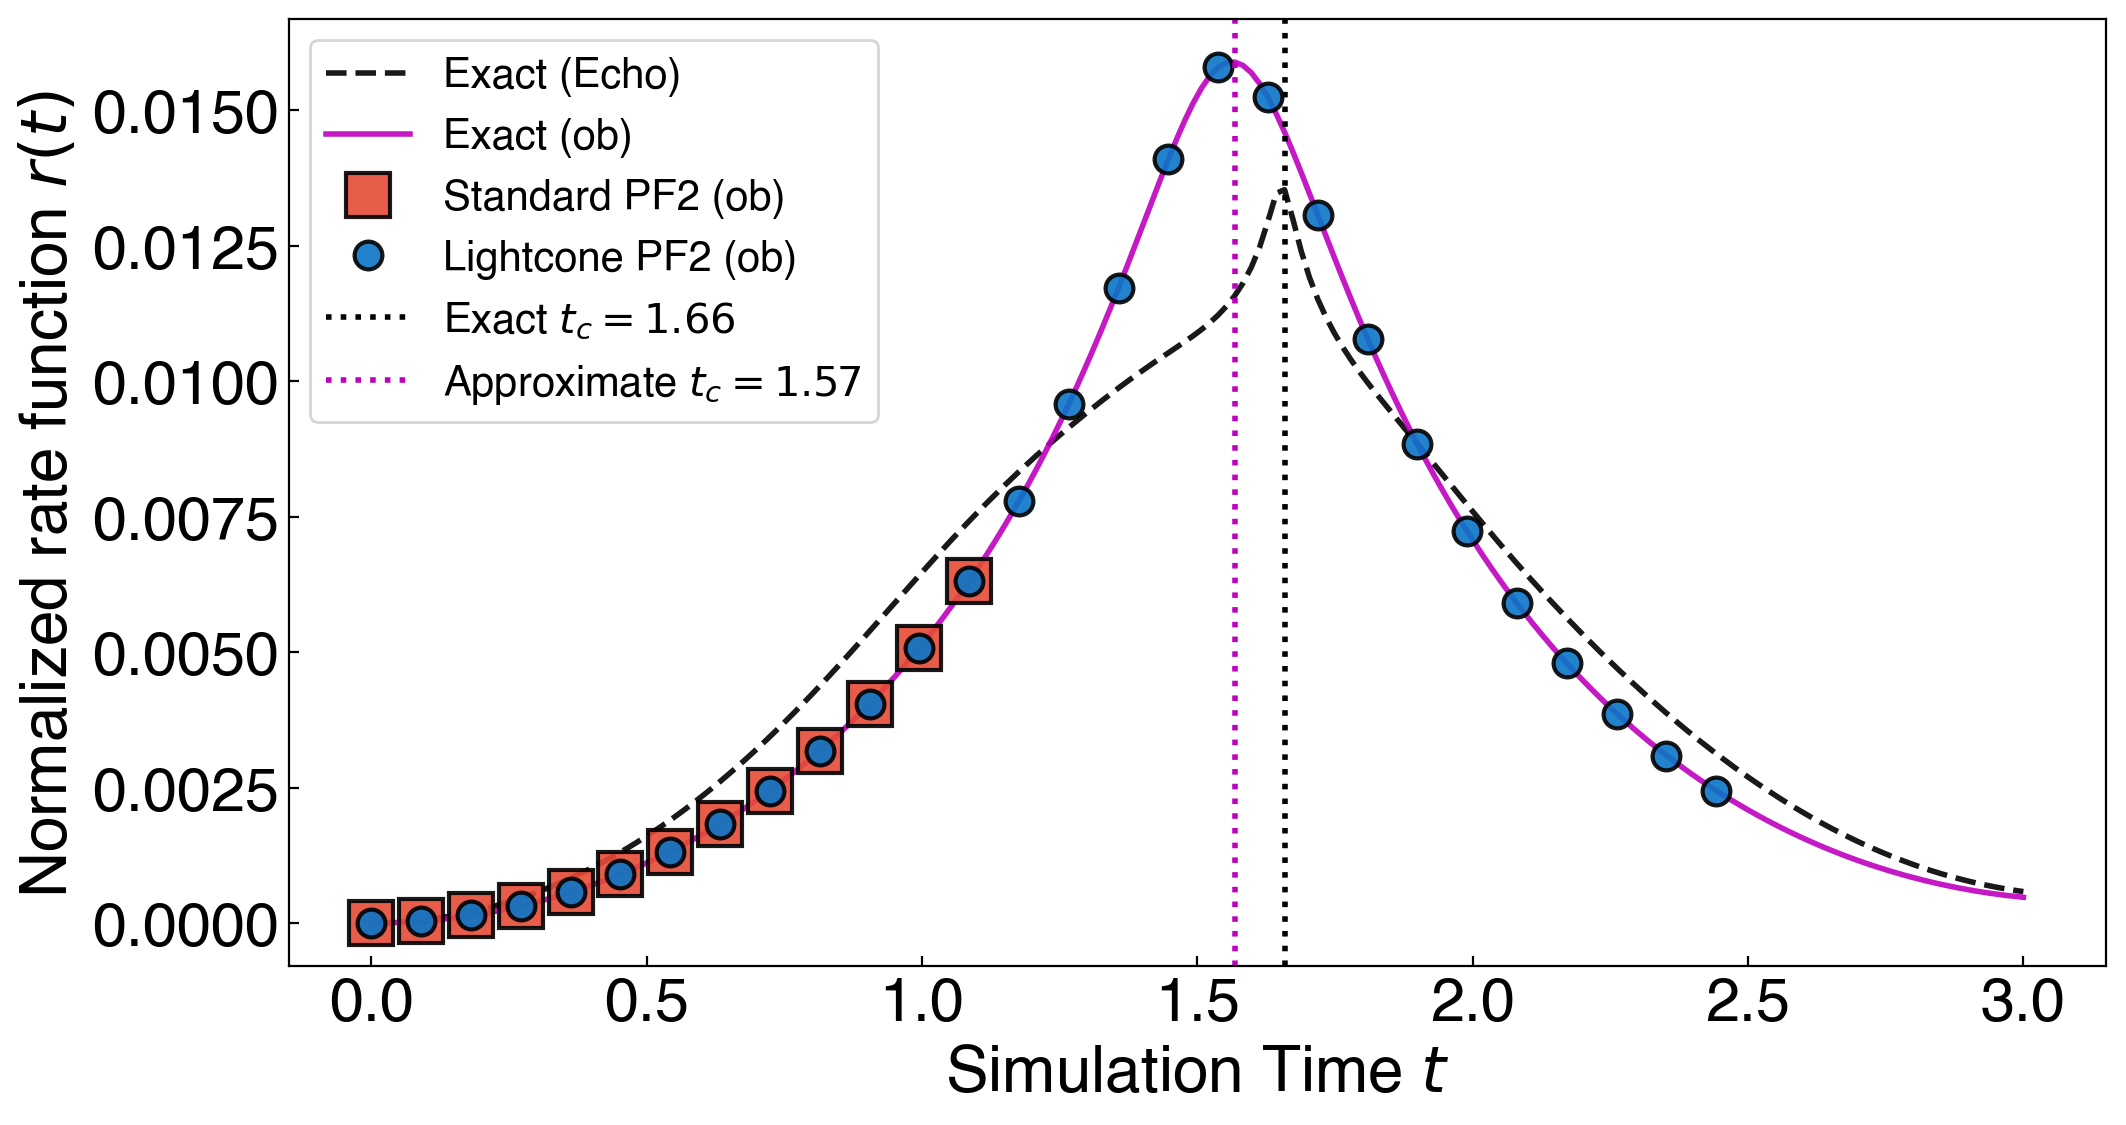

In [126]:
from qiskit.quantum_info import Statevector, DensityMatrix
import itertools as it
from dqpt import *  


# h_list = [H1d.ham_xyz[0], H1d.ham_xyz[2]]
proj0 = [''.join(i) for i in list(it.product(['I', 'Z'], repeat=n))]
k = 1
print('local observables: ', generate_proj_pstrs(n, k)[:2**k])
# local_ob = SparsePauliOp.from_list([(pstr, 1) for pstr in generate_proj_pstrs(n, k)]).simplify()
local_ob = SparsePauliOp.from_list([(pstr, 1/2**k) for pstr in generate_proj_pstrs(n, k)[:2**k]]).simplify()
# local_ob = SparsePauliOp.from_list([(pstr, 1) for pstr in proj0]).simplify()
# local_ob = SparsePauliOp.from_list([(pstr, 1) for pstr in proj0[:4]])
init_state = Statevector.from_label('0'*n)
init_dm = DensityMatrix(init_state).to_operator()
# init_dm
echo_op = SparsePauliOp(proj0, [1j/8]*len(proj0))
echo_op_dt = H @ echo_op - echo_op @ H
echo_op_dt.simplify()
rate_dt_op = (H + echo_op @ H @ echo_op).simplify()

echo_list, echo_pf_list, echo_local_list, echo_local_pf_lc_list, echo_local_pf_st_list = [], [], [], [], []

for t in t_list:
    print('+', end='')
    exact_U = expm(-1j * t * H.to_matrix())
    apprx_U_lc = pf_r([h.to_matrix() for h in h_list], t, r_lc_bnd, order=2)
    apprx_U_st = pf_r([h.to_matrix() for h in h_list], t, r_st_bnd, order=2)
    final_state = exact_U @ init_state.data
    final_state_pf_lc = apprx_U_lc @ init_state.data
    final_state_pf_st = apprx_U_st @ init_state.data
    echo = np.abs(init_state.data.conj() @ final_state)**2
    echo_pf = np.abs(init_state.data.conj() @ final_state_pf_lc)**2
    echo_local = final_state.conj() @ local_ob.to_matrix() @ final_state
    echo_local_pf_lc = final_state_pf_lc.conj() @ local_ob.to_matrix() @ final_state_pf_lc
    echo_local_pf_st = final_state_pf_st.conj() @ local_ob.to_matrix() @ final_state_pf_st
    # print('echo: ', echo)
    echo_list.append(echo)
    echo_pf_list.append(echo_pf)
    echo_local_list.append(echo_local.real)
    echo_local_pf_lc_list.append(echo_local_pf_lc.real)
    echo_local_pf_st_list.append(echo_local_pf_st.real)

print('\necho_local_list: ', echo_local_list)
print('echo_local_pf_lc_list: ', echo_local_pf_lc_list)
rate_list = [-1/n*np.log(echo) for echo in echo_list]
rate_pf_list = [-1/n*np.log(echo) for echo in echo_pf_list]
rate_local_list = [-1/n*np.log(echo) for echo in echo_local_list]
rate_local_pf_lc_list = [-1/n*np.log(echo) for echo in echo_local_pf_lc_list]
rate_local_pf_st_list = [-1/n*np.log(echo) for echo in echo_local_pf_st_list]

fig, axes = plt.subplots(1, 1, figsize=(11, 6), layout='tight', sharex=True)

axes.plot(t_list, rate_list/sum(rate_list), '--', label=rf'Exact (Echo)', c='k')
axes.plot(t_list, rate_local_list/sum(rate_local_list), '-', label=rf'Exact (ob)', c='m')
sparse = 6

t_st_index = find_closest_index(t_list, t_st)
axes.plot(t_list[:t_st_index][::sparse], rate_local_pf_st_list[:t_st_index][::sparse]/sum(rate_local_pf_st_list), 's', label=rf'Standard PF2 (ob)', markersize=16, c="#E64B35FF")
t_lc_index = find_closest_index(t_list, t_lc)
axes.plot(t_list[:t_lc_index][::sparse], rate_local_pf_lc_list[:t_lc_index][::sparse]/sum(rate_local_pf_lc_list), 'o', label=rf'Lightcone PF2 (ob)', markersize=10, c="#0A75C7FF")

t_c = t_list[np.argmax(rate_list)]
t_c_appro = t_list[np.argmax(rate_local_pf_lc_list)]
# axes2 = axes.twinx()
# axes2.plot(t_list, np.array(rate_local_pf_st_list)-np.array(rate_local_list), '--', label=rf'Echo', c='k')

axes.axvline(t_c, ls=':', color='k', label=f'Exact $t_c = {t_c:.2f}$')
axes.axvline(t_c_appro, ls=':', color='k', label=f'Approximate $t_c = {t_c_appro:.2f}$', c='m')

axes.legend(loc='upper left'); axes.set_xlabel('Simulation Time $t$'); axes.set_ylabel('Normalized rate function $r(t)$')
# axes[0].text(-.09, 1.0, f'(a)', transform=axes[0].transAxes, size=24, weight='bold')
# fig.savefig(f'{figs_dir}/rate_function_{prefix}_n={n}_eps={eps}.pdf', bbox_inches='tight')

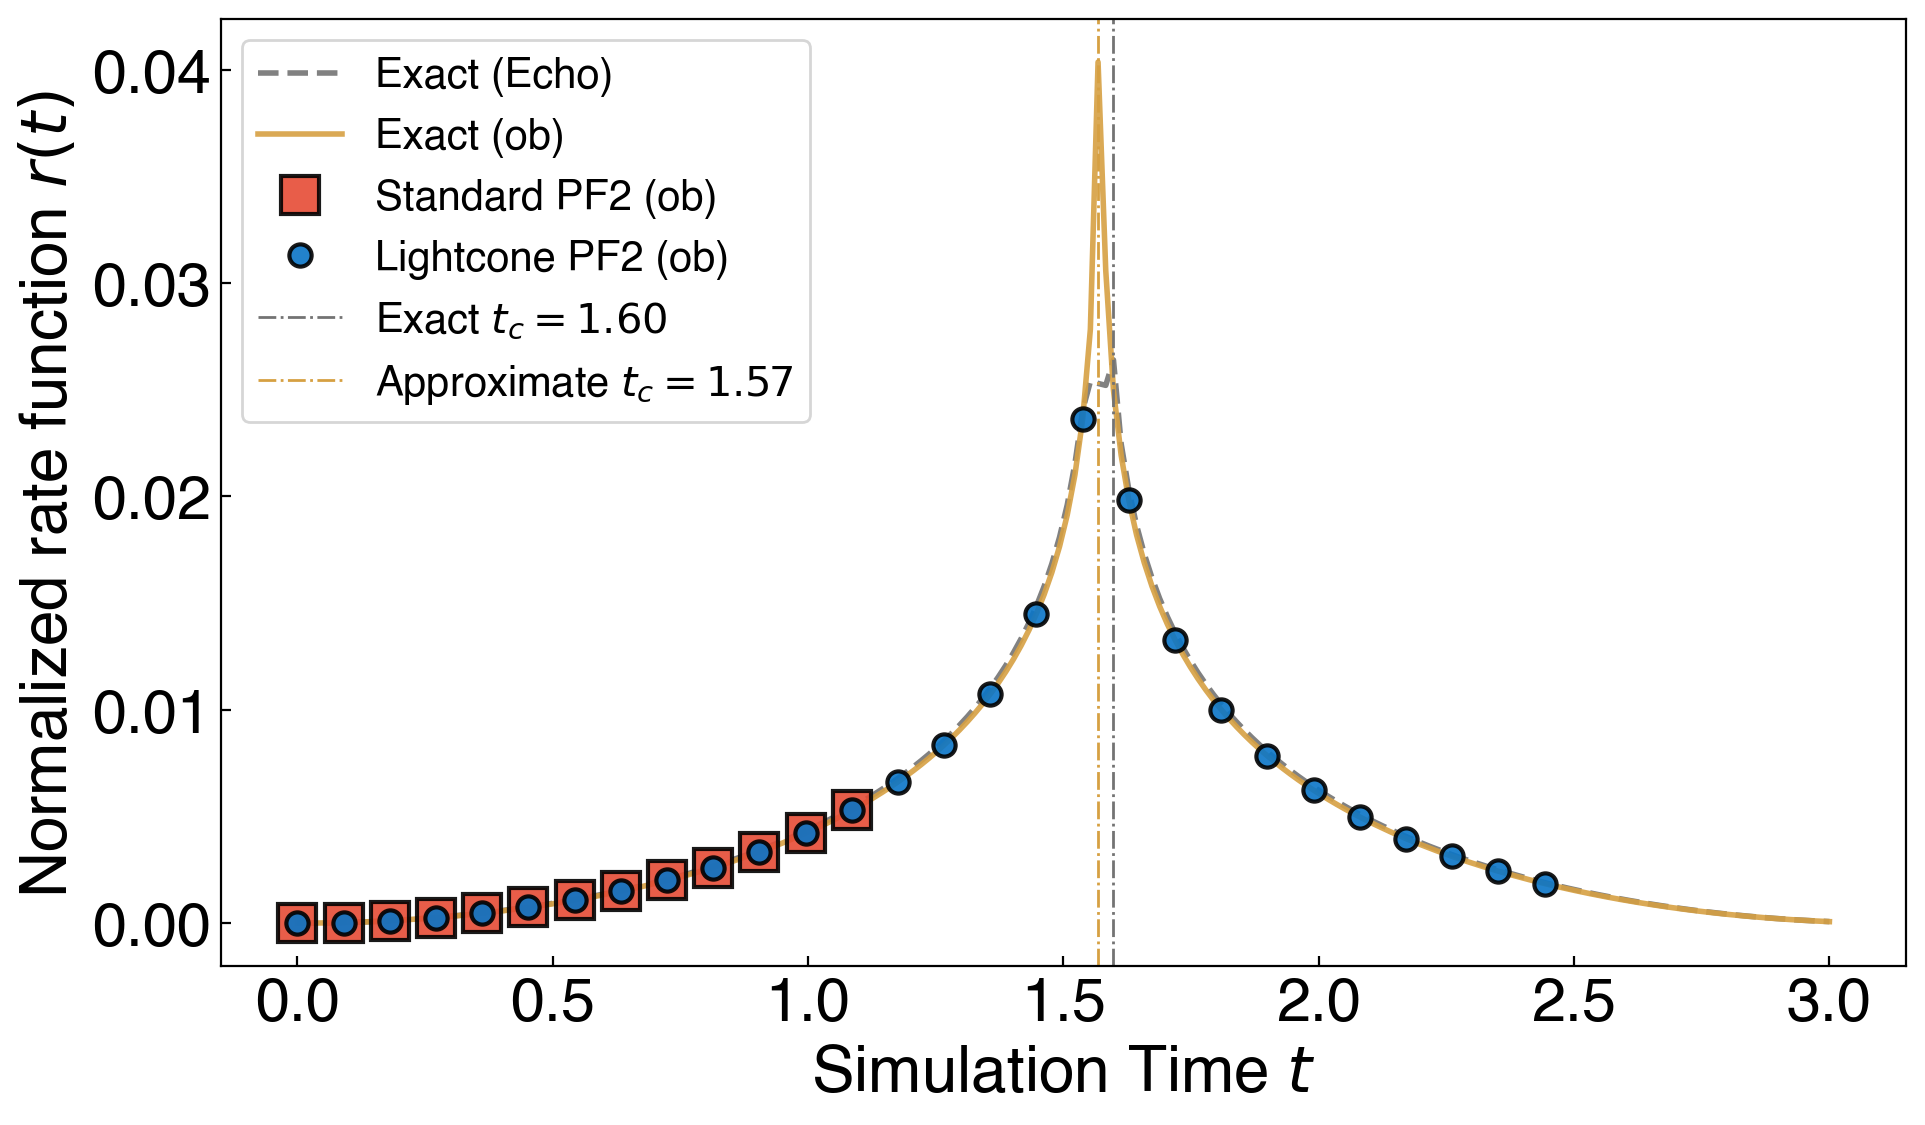

In [110]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6), layout='tight', sharex=True)

axes.plot(t_list, rate_list/sum(rate_list), '--', label=rf'Exact (Echo)', c='#737373')
axes.plot(t_list, rate_local_list/sum(rate_local_list), '-', label=rf'Exact (ob)', c='#D6A042')
sparse = 6

t_st_index = find_closest_index(t_list, t_st)
axes.plot(t_list[:t_st_index][::sparse], rate_local_pf_st_list[:t_st_index][::sparse]/sum(rate_local_pf_st_list), 's', label=rf'Standard PF2 (ob)', markersize=14, c="#E64B35FF")
t_lc_index = find_closest_index(t_list, t_lc)
axes.plot(t_list[:t_lc_index][::sparse], rate_local_pf_lc_list[:t_lc_index][::sparse]/sum(rate_local_pf_lc_list), 'o', label=rf'Lightcone PF2 (ob)', markersize=8, c="#0A75C7FF")

t_c = t_list[np.argmax(rate_list)]
t_c_appro = t_list[np.argmax(rate_local_pf_lc_list)]
# axes2 = axes.twinx()
# axes2.plot(t_list, np.array(rate_local_pf_st_list)-np.array(rate_local_list), '--', label=rf'Echo', c='k')

axes.axvline(t_c, ls='-.', color='#737373', label=f'Exact $t_c = {t_c:.2f}$', linewidth=1.0)
axes.axvline(t_c_appro, ls='-.', color='#D6A042', label=f'Approximate $t_c = {t_c_appro:.2f}$', linewidth=1.0)

axes.legend(loc='upper left'); axes.set_xlabel('Simulation Time $t$'); axes.set_ylabel('Normalized rate function $r(t)$')
# axes[0].text(-.09, 1.0, f'(a)', transform=axes[0].transAxes, size=24, weight='bold')
fig.savefig(f'{figs_dir}/rate_function_{prefix}_n={n}_eps={eps}.pdf', bbox_inches='tight')

In [ ]:
m_list = np.linspace(0, 10, 100)
test1_list = []